In [198]:
# Импортируем основные библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import shap

import warnings

warnings.filterwarnings("ignore")

# Важная настройка для корректной настройки pipeline!
import sklearn

sklearn.set_config(transform_output="pandas")

# Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin

# Preprocessing
from sklearn.svm import SVC
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.preprocessing import (OneHotEncoder, StandardScaler, RobustScaler, MinMaxScaler, OrdinalEncoder, TargetEncoder)
from category_encoders.cat_boost import CatBoostEncoder

from sklearn.model_selection import GridSearchCV, KFold

# for model learning
from sklearn.model_selection import (
    train_test_split,
    RandomizedSearchCV,
    cross_val_score,
)

# models
from sklearn.neighbors import KNeighborsClassifier, RadiusNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, BaggingClassifier
from catboost import CatBoostRegressor

# Metrics
from sklearn.metrics import accuracy_score


# tunning hyperparamters model
# import optuna

from tabulate import tabulate

In [199]:
# Включаем настройку для отображения всех столбцов датафреймов
pd.set_option("display.max_columns", None)

In [200]:
# Читаем тренировочные данные
train = pd.read_csv("train.csv")

In [201]:
# Проверяем записи на дубликаты
train.duplicated().sum()

0

In [202]:
(train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [203]:
test = pd.read_csv("test.csv")
test.duplicated().sum()

0

In [204]:
# Разделим датафрейм на числовые и категориальные данные.
num_features = train.select_dtypes(exclude="object")
cat_features = train.select_dtypes(include="object")

In [205]:
num_features

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
0,1,60,65.0,8450,7,5,2003,2003,196.0,706,0,150,856,856,854,0,1710,1,0,2,1,3,1,8,0,2003.0,2,548,0,61,0,0,0,0,0,2,2008,208500
1,2,20,80.0,9600,6,8,1976,1976,0.0,978,0,284,1262,1262,0,0,1262,0,1,2,0,3,1,6,1,1976.0,2,460,298,0,0,0,0,0,0,5,2007,181500
2,3,60,68.0,11250,7,5,2001,2002,162.0,486,0,434,920,920,866,0,1786,1,0,2,1,3,1,6,1,2001.0,2,608,0,42,0,0,0,0,0,9,2008,223500
3,4,70,60.0,9550,7,5,1915,1970,0.0,216,0,540,756,961,756,0,1717,1,0,1,0,3,1,7,1,1998.0,3,642,0,35,272,0,0,0,0,2,2006,140000
4,5,60,84.0,14260,8,5,2000,2000,350.0,655,0,490,1145,1145,1053,0,2198,1,0,2,1,4,1,9,1,2000.0,3,836,192,84,0,0,0,0,0,12,2008,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,62.0,7917,6,5,1999,2000,0.0,0,0,953,953,953,694,0,1647,0,0,2,1,3,1,7,1,1999.0,2,460,0,40,0,0,0,0,0,8,2007,175000
1456,1457,20,85.0,13175,6,6,1978,1988,119.0,790,163,589,1542,2073,0,0,2073,1,0,2,0,3,1,7,2,1978.0,2,500,349,0,0,0,0,0,0,2,2010,210000
1457,1458,70,66.0,9042,7,9,1941,2006,0.0,275,0,877,1152,1188,1152,0,2340,0,0,2,0,4,1,9,2,1941.0,1,252,0,60,0,0,0,0,2500,5,2010,266500
1458,1459,20,68.0,9717,5,6,1950,1996,0.0,49,1029,0,1078,1078,0,0,1078,1,0,1,0,2,1,5,0,1950.0,1,240,366,0,112,0,0,0,0,4,2010,142125


In [206]:
cat_features

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,Heating,HeatingQC,CentralAir,Electrical,KitchenQual,Functional,FireplaceQu,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
0,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,BrkFace,Gd,TA,PConc,Gd,TA,No,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,NaN,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
1,RL,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,Gable,CompShg,MetalSd,MetalSd,NaN,TA,TA,CBlock,Gd,TA,Gd,ALQ,Unf,GasA,Ex,Y,SBrkr,TA,Typ,TA,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
2,RL,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,BrkFace,Gd,TA,PConc,Gd,TA,Mn,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,TA,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
3,RL,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,Gable,CompShg,Wd Sdng,Wd Shng,NaN,TA,TA,BrkTil,TA,Gd,No,ALQ,Unf,GasA,Gd,Y,SBrkr,Gd,Typ,Gd,Detchd,Unf,TA,TA,Y,NaN,NaN,NaN,WD,Abnorml
4,RL,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,BrkFace,Gd,TA,PConc,Gd,TA,Av,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,TA,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,NaN,TA,TA,PConc,Gd,TA,No,Unf,Unf,GasA,Ex,Y,SBrkr,TA,Typ,TA,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
1456,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NWAmes,Norm,Norm,1Fam,1Story,Gable,CompShg,Plywood,Plywood,Stone,TA,TA,CBlock,Gd,TA,No,ALQ,Rec,GasA,TA,Y,SBrkr,TA,Min1,TA,Attchd,Unf,TA,TA,Y,NaN,MnPrv,NaN,WD,Normal
1457,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Crawfor,Norm,Norm,1Fam,2Story,Gable,CompShg,CemntBd,CmentBd,NaN,Ex,Gd,Stone,TA,Gd,No,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,Gd,Attchd,RFn,TA,TA,Y,NaN,GdPrv,Shed,WD,Normal
1458,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,Hip,CompShg,MetalSd,MetalSd,NaN,TA,TA,CBlock,TA,TA,Mn,GLQ,Rec,GasA,Gd,Y,FuseA,Gd,Typ,NaN,Attchd,Unf,TA,TA,Y,NaN,NaN,NaN,WD,Normal


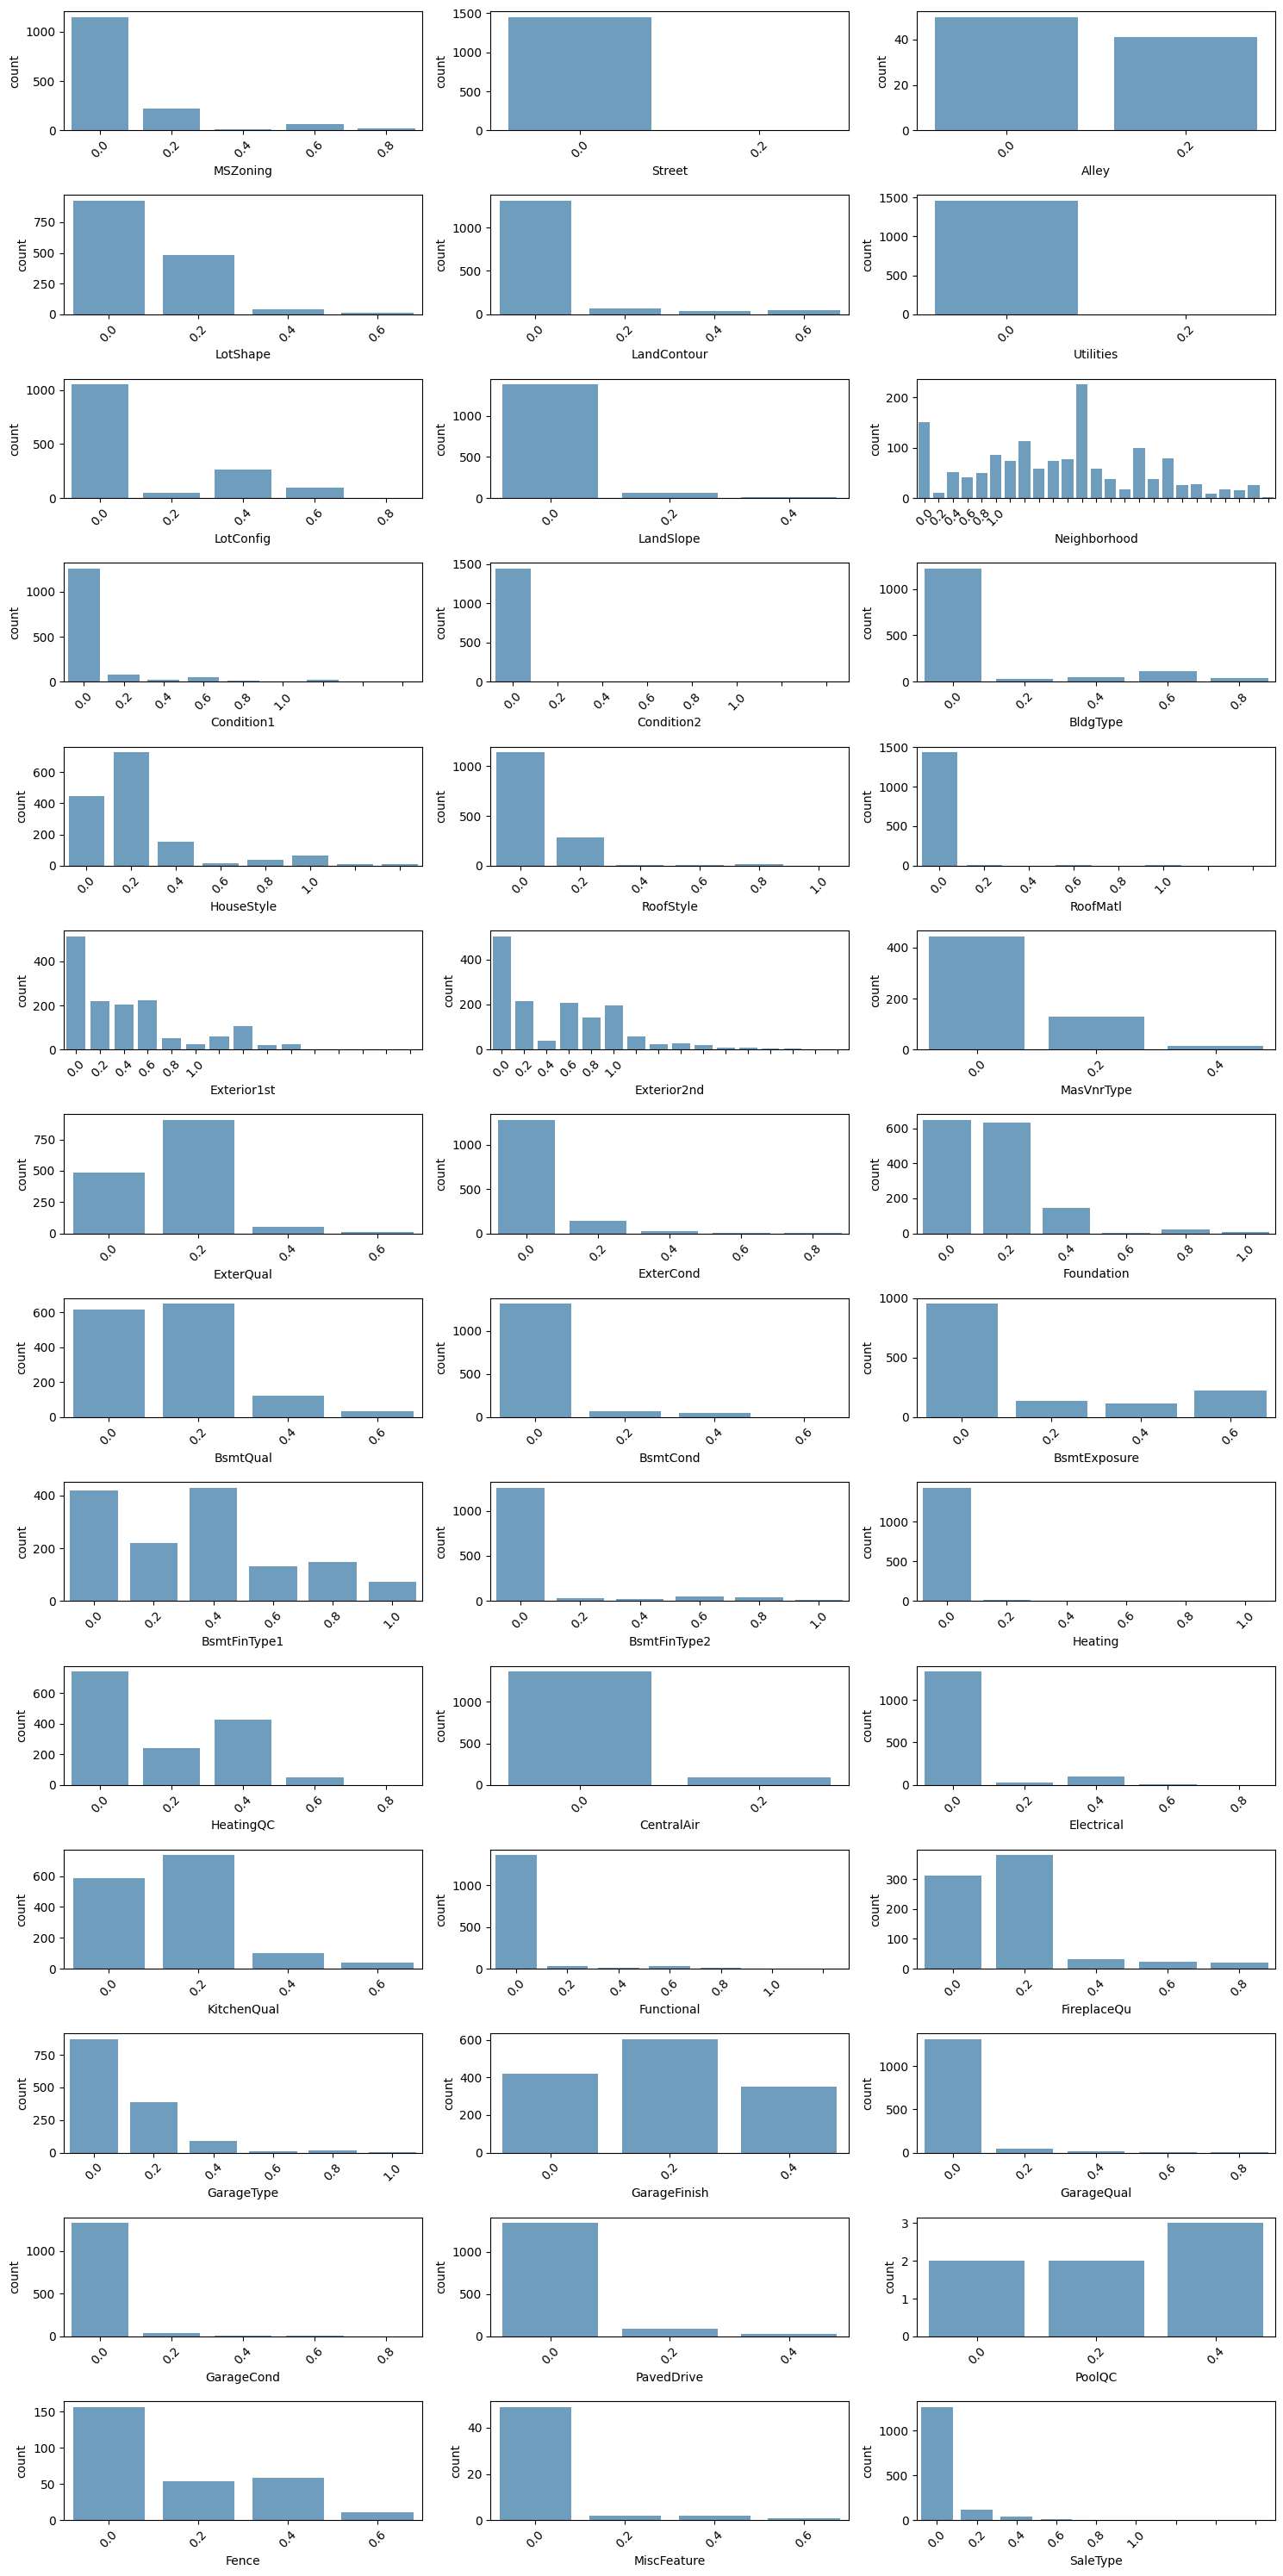

In [207]:
# Распределение категориальных признаков
fig, axes = plt.subplots(round(len(cat_features.columns) / 3), 3, figsize=(15, 30))

for i, ax in enumerate(fig.axes):
    if i < len(cat_features):
        ax.set_xticklabels(ax.xaxis.get_majorticklabels(), rotation=45)
        sns.countplot(x=cat_features.columns[i], alpha=0.7, data=cat_features, ax=ax)

fig.tight_layout();

In [208]:
#распределение числовые признаки


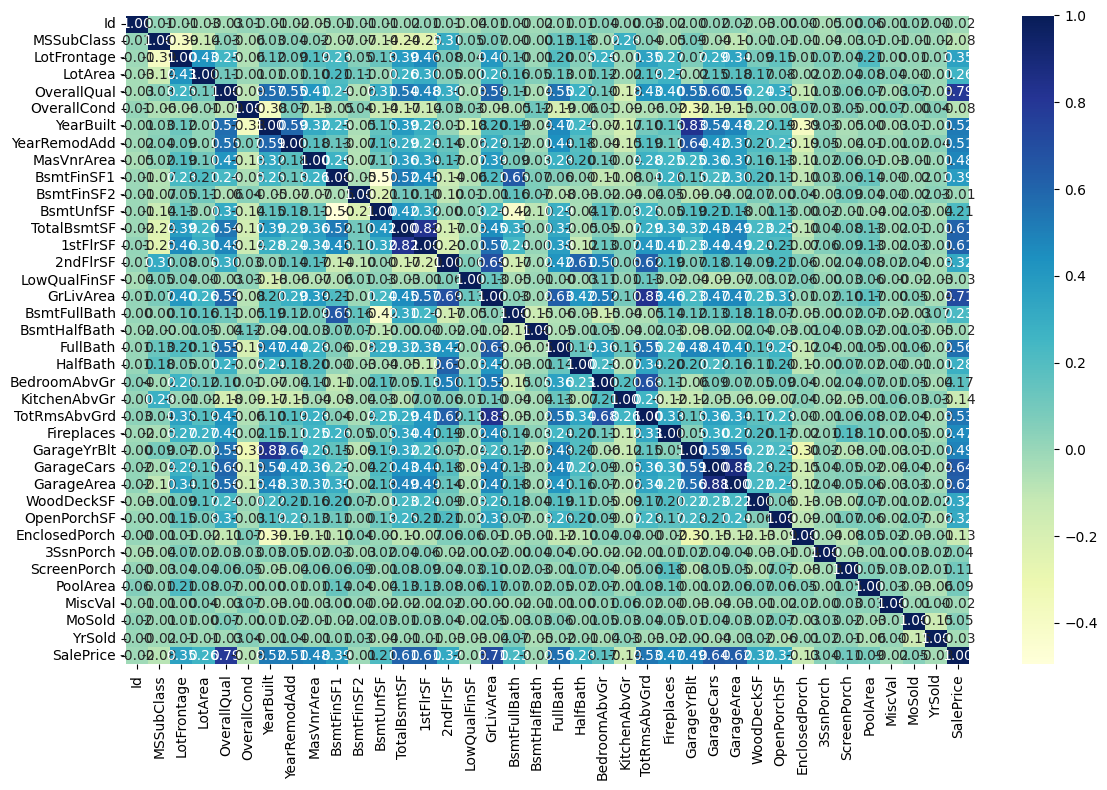

In [209]:
#после преобразования в чииловые признаки
correlation_matrix = num_features.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, fmt='0.2f', cmap='YlGnBu', annot=True)
plt.tight_layout()
plt.show()

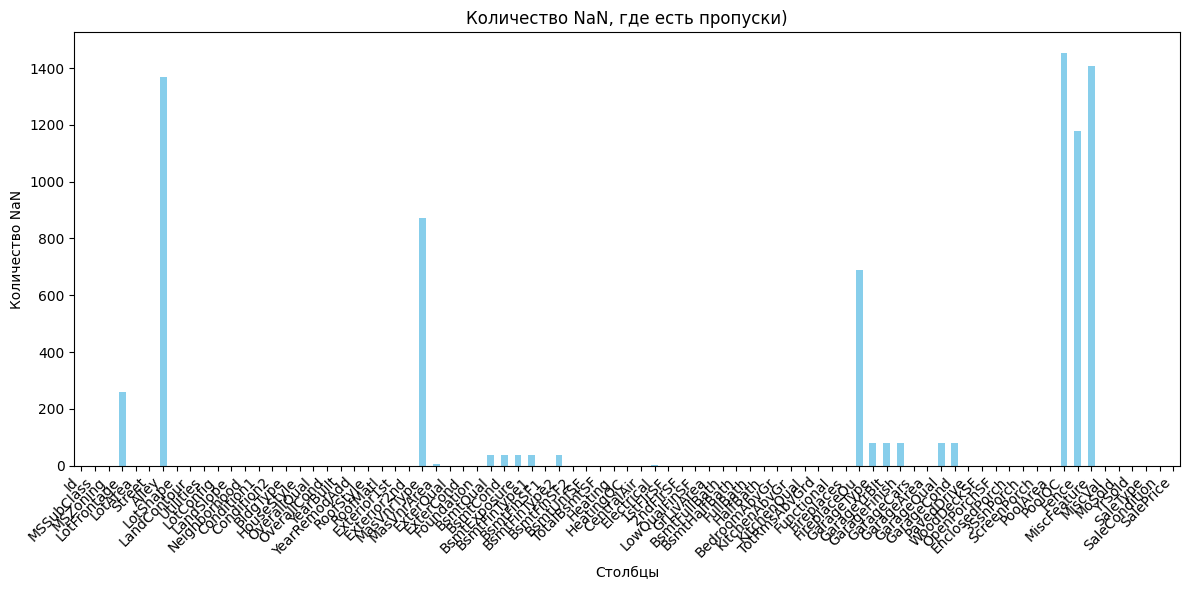

In [210]:
nan_counts = train.isna().sum()

# Построение столбчатой диаграммы
plt.figure(figsize=(12, 6))
nan_counts.plot(kind='bar', color='skyblue')
plt.title('Количество NaN, где есть пропуски)')
plt.xlabel('Столбцы')
plt.ylabel('Количество NaN')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show();

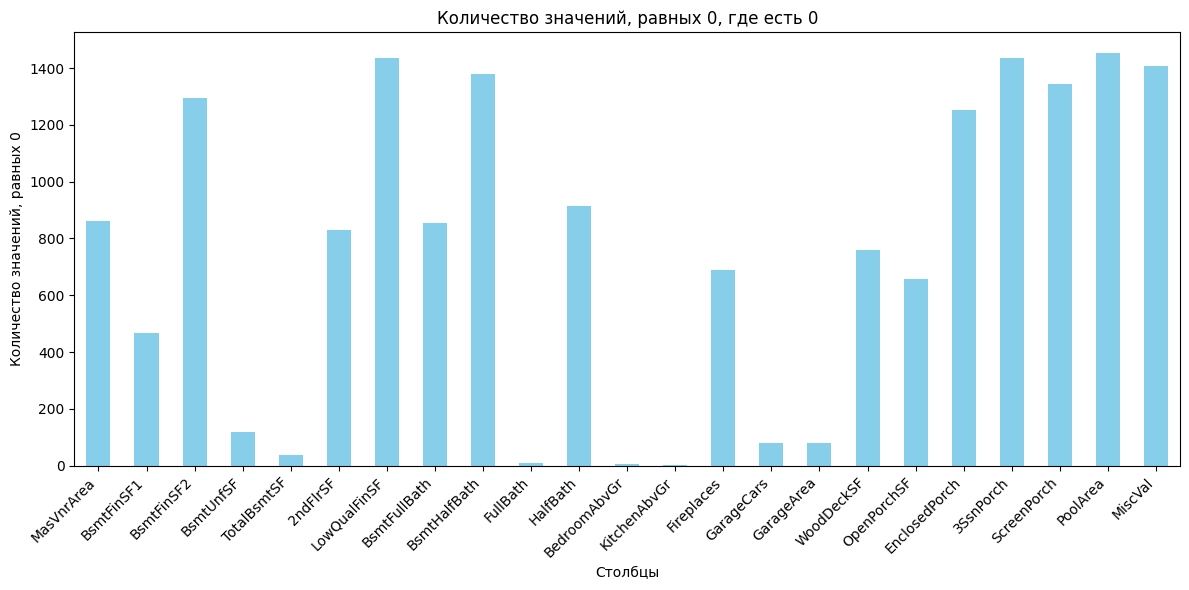

In [211]:
zero_counts = (train == 0).sum()
zero_counts = zero_counts[zero_counts > 0]
plt.figure(figsize=(12, 6))
zero_counts.plot(kind='bar', color='skyblue')
plt.title('Количество значений, равных 0, где есть 0')
plt.xlabel('Столбцы')
plt.ylabel('Количество значений, равных 0')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

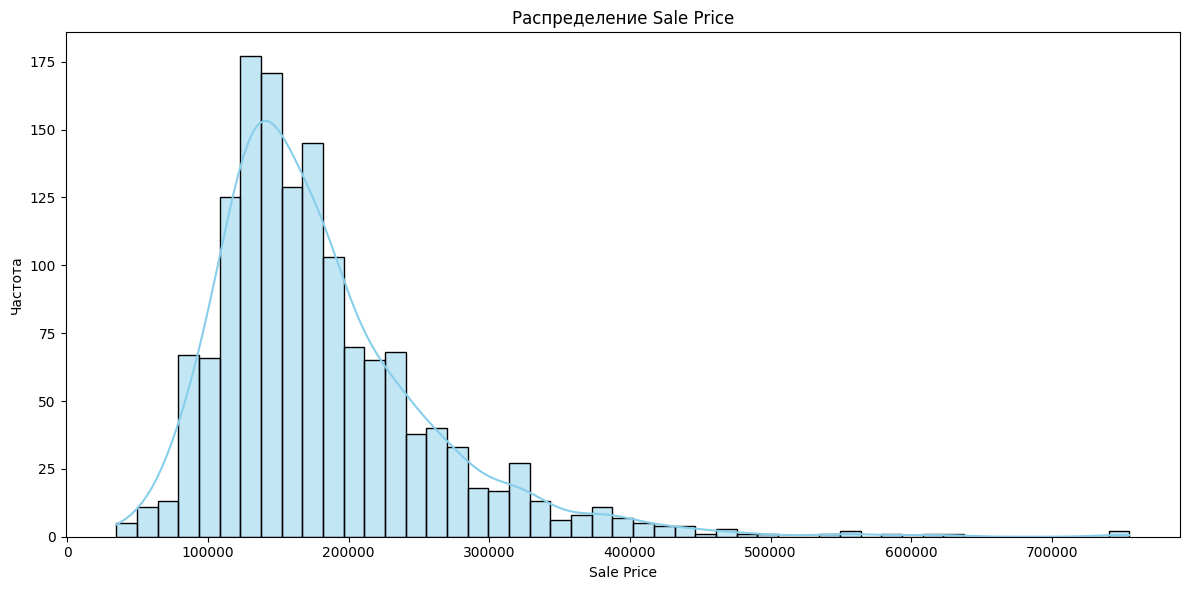

In [212]:
plt.figure(figsize=(12, 6))
sns.histplot(train['SalePrice'], kde=True, color='skyblue')  # Гистограмма с ядерной оценкой плотности, используется для визуализации формы распределения данных и предоставляет непараметрическую оценку плотности
plt.title('Распределение Sale Price')
plt.xlabel('Sale Price')
plt.ylabel('Частота')
plt.tight_layout()
plt.show()

In [213]:
train['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

In [249]:
# Отделяем таргет от признаков
# X, y = train.iloc[:, :-1], train.iloc[:, -1]

# X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=888)

In [215]:
# Собираем тренировоные и тестовые данные вместе для препроцессинга
overall_df = pd.concat((train, test), ignore_index=True, axis=0)

In [216]:
overall_df.iloc[1460]

Id                 1461
MSSubClass           20
MSZoning             RH
LotFrontage        80.0
LotArea           11622
                  ...  
MoSold                6
YrSold             2010
SaleType             WD
SaleCondition    Normal
SalePrice           NaN
Name: 1460, Length: 81, dtype: object

In [217]:
overall_df.isna().sum()[overall_df.isna().sum() > 0]

MSZoning           4
LotFrontage      486
Alley           2721
Utilities          2
Exterior1st        1
Exterior2nd        1
MasVnrType      1766
MasVnrArea        23
BsmtQual          81
BsmtCond          82
BsmtExposure      82
BsmtFinType1      79
BsmtFinSF1         1
BsmtFinType2      80
BsmtFinSF2         1
BsmtUnfSF          1
TotalBsmtSF        1
Electrical         1
BsmtFullBath       2
BsmtHalfBath       2
KitchenQual        1
Functional         2
FireplaceQu     1420
GarageType       157
GarageYrBlt      159
GarageFinish     159
GarageCars         1
GarageArea         1
GarageQual       159
GarageCond       159
PoolQC          2909
Fence           2348
MiscFeature     2814
SaleType           1
SalePrice       1459
dtype: int64

In [218]:
overall_df

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706.0,Unf,0.0,150.0,856.0,GasA,Ex,Y,SBrkr,856,854,0,1710,1.0,0.0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2.0,548.0,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500.0
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,NaN,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978.0,Unf,0.0,284.0,1262.0,GasA,Ex,Y,SBrkr,1262,0,0,1262,0.0,1.0,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2.0,460.0,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500.0
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486.0,Unf,0.0,434.0,920.0,GasA,Ex,Y,SBrkr,920,866,0,1786,1.0,0.0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2.0,608.0,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500.0
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,NaN,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216.0,Unf,0.0,540.0,756.0,GasA,Gd,Y,SBrkr,961,756,0,1717,1.0,0.0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3.0,642.0,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000.0
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655.0,Unf,0.0,490.0,1145.0,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1.0,0.0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3.0,836.0,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2914,2915,160,RM,21.0,1936,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,MeadowV,Norm,Norm,Twnhs,2Story,4,7,1970,1970,Gable,CompShg,CemntBd,CmentBd,NaN,0.0,TA,TA,CBlock,TA,TA,No,Unf,0.0,Unf,0.0,546.0,546.0,GasA,Gd,Y,SBrkr,546,546,0,1092,0.0,0.0,1,1,3,1,TA,5,Typ,0,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,Y,0,0,0,0,0,0,NaN,NaN,NaN,0,6,2006,WD,Normal,NaN
2915,2916,160,RM,21.0,1894,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,MeadowV,Norm,Norm,TwnhsE,2Story,4,5,1970,1970,Gable,CompShg,CemntBd,CmentBd,NaN,0.0,TA,TA,CBlock,TA,TA,No,Rec,252.0,Unf,0.0,294.0,546.0,GasA,TA,Y,SBrkr,546,546,0,1092,0.0,0.0,1,1,3,1,TA,6,Typ,0,NaN,CarPort,1970.0,Unf,1.0,286.0,TA,TA,Y,0,24,0,0,0,0,NaN,NaN,NaN,0,4,2006,WD,Abnorml,NaN
2916,2917,20,RL,160.0,20000,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,1Fam,1Story,5,7,1960,1996,Gable,CompShg,VinylSd,VinylSd,NaN,0.0,TA,TA,CBlock,TA,TA,No,ALQ,1224.0,Unf,0.0,0.0,1224.0,GasA,Ex,Y,SBrkr,1224,0,0,1224,1.0,0.0,1,0,4,1,TA,7,Typ,1,TA,Detchd,1960.0,Unf,2.0,576.0,TA,TA,Y,474,0,0,0,0,0,NaN,NaN,NaN,0,9,2006,WD,Abnorml,NaN
2917,2918,85,RL,62.0,10441,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,

In [219]:
# Получаем список колонок с NaN объектами и их количеством
df_nan = overall_df.isna().sum()[overall_df.isna().sum() > 0]
df_nan.sort_values(ascending=False)

PoolQC          2909
MiscFeature     2814
Alley           2721
Fence           2348
MasVnrType      1766
SalePrice       1459
FireplaceQu     1420
LotFrontage      486
GarageCond       159
GarageYrBlt      159
GarageFinish     159
GarageQual       159
GarageType       157
BsmtExposure      82
BsmtCond          82
BsmtQual          81
BsmtFinType2      80
BsmtFinType1      79
MasVnrArea        23
MSZoning           4
Functional         2
BsmtHalfBath       2
BsmtFullBath       2
Utilities          2
KitchenQual        1
TotalBsmtSF        1
BsmtUnfSF          1
GarageCars         1
GarageArea         1
BsmtFinSF2         1
BsmtFinSF1         1
Exterior2nd        1
Exterior1st        1
SaleType           1
Electrical         1
dtype: int64

#### Смотрим на описание данных и что пропущенные значения из себя представляют.
> PoolQC: Pool quality \
       NA - No Pool

> MiscFeature: Miscellaneous feature not covered in other categories \
       NA - None

> Alley: Type of alley access to property \
       NA - No alley access

> Fence: Fence quality \
       NA - No Fence

> MasVnrType: Masonry veneer type \
       None - None

> FireplaceQu: Fireplace quality \
       NA - No Fireplace

> LotFrontage: Linear feet of street connected to property \
       Нет дополнительной информации.

> GarageFinish: Interior finish of the garage \
       NA - No Garage

> GarageQual: Garage quality \
       NA - No Garage

> GarageCond: Garage condition \
       NA - No Garage

> GarageYrBlt: Year garage was built

> GarageType: Garage location \
       NA - No Garage

> BsmtExposure: Refers to walkout or garden level walls \
       NA - No Basement

> BsmtCond: Evaluates the general condition of the basement \
       NA - No Basement

> BsmtQual: Evaluates the height of the basement \
       NA - No Basement

> BsmtFinType2: Rating of basement finished area (if multiple types) \
       NA - No Basement

> BsmtFinType1: Rating of basement finished area \
       NA - No Basement

> MasVnrArea: Masonry veneer area in square feet \
       Нет дополнительной информации.

> MSZoning: Identifies the general zoning classification of the sale. \
       Нет дополнительной информации.

> BsmtFullBath: Basement full bathrooms \
       Нет дополнительной информации.

> BsmtHalfBath: Basement half bathrooms \
       Нет дополнительной информации.

> Functional: Home functionality (Assume typical unless deductions are warranted)

> Utilities: Type of utilities available \
       Нет дополнительной информации.

> GarageArea: Size of garage in square feet \
       Нет дополнительной информации.

> GarageCars: Size of garage in car capacity \
       Нет дополнительной информации.

> Electrical: Electrical system \
       Нет дополнительной информации.

> KitchenQual: Kitchen quality \
       Нет дополнительной информации.

> TotalBsmtSF: Total square feet of basement area \
       Нет дополнительной информации.

> Unfinished square feet of basement area \
       Нет дополнительной информации.

> BsmtFinSF2: Type 2 finished square feet \
       Нет дополнительной информации.

> BsmtFinSF1: Type 1 finished square feet \
       Нет дополнительной информации.

> Exterior1st: Exterior covering on house \
       Нет дополнительной информации.

> Exterior2nd: Exterior covering on house (if more than one material) \
       Нет дополнительной информации.

> SaleType: Type of sale \
       Нет дополнительной информации.

In [220]:
# Cтроим пайплайн для заполнения NaN значений
NAImputerValues = ["Alley", "MasVnrType", "BsmtQual", "Functional", "BsmtCond", "BsmtExposure", "BsmtFinType1", "BsmtFinType2", "FireplaceQu", "GarageType", "GarageFinish", "GarageQual", "GarageCond", "PoolQC", "Fence", "MiscFeature", ]
MostFrequentImputerValues = ["Utilities", "MSZoning", "Exterior1st", "Exterior2nd", "Electrical", "KitchenQual", "SaleType"]
ZeroValuesImputerValues = ["LotFrontage", "MasVnrArea", "BsmtFinSF1", "BsmtFinSF2", "BsmtUnfSF", "TotalBsmtSF", "BsmtFullBath", "BsmtHalfBath", "GarageCars", "GarageArea"]
MedianImputerValues = ["GarageYrBlt"]

my_imputer = ColumnTransformer(
    transformers=[("MostFrequentImputer", SimpleImputer(strategy="most_frequent"), MostFrequentImputerValues),
                  ("NAImputer", SimpleImputer(strategy="constant", fill_value="NA"), NAImputerValues),
                  ("ZeroValuesImputer", SimpleImputer(strategy="constant", fill_value=0), ZeroValuesImputerValues),
                  ("MedianImputer", SimpleImputer(strategy="median"), MedianImputerValues)
                 ],
    verbose_feature_names_out = False,
    remainder = "passthrough")

In [221]:
filled_df = my_imputer.fit_transform(overall_df)

In [222]:
filled_df.isna().sum()[filled_df.isna().sum() > 0]

SalePrice    1459
dtype: int64

In [223]:
# Столбец, который планируем кодировать с помощью OneHotEncoder
one_hot_encoding_columns = [
    "Street", "Alley", "Utilities", "RoofStyle", "RoofMatl", "MasVnrType", "Foundation", "CentralAir",
    "GarageFinish", "PavedDrive",
]

# Столбец, который планируем кодировать порядково, с помощью OrdinalEncoder
ordinal_encoding_columns = [
    "LotShape", "LandContour", "LotConfig", "LandSlope", "ExterQual", "ExterCond",
    "BsmtQual", "BsmtCond", "BsmtExposure", "BsmtFinType1", "BsmtFinType2",
    "HeatingQC", "Electrical", "KitchenQual", "FireplaceQu", 
    "GarageQual", "GarageCond", "PoolQC", "Fence",
]

# Столбец, который планируем кодировать с помощью CatboostEncoder
catboost_encoding_columns = [
    "MSZoning", "Neighborhood", "Condition1", "Condition2", "BldgType", "HouseStyle",
    "Exterior1st", "Exterior2nd", "Heating", "Functional", "GarageType",
    "MiscFeature", "SaleType", "SaleCondition", 
]

In [224]:
# Оборачиваем Encoder в ColumnTransformer
my_encoder = ColumnTransformer(
    [
        ("one_hot_encoding", OneHotEncoder(sparse_output=False), one_hot_encoding_columns,),
        ("ordinal_encoding", OrdinalEncoder(), ordinal_encoding_columns),
        ("catboost_encoding", CatBoostEncoder(), catboost_encoding_columns),
    ],
    verbose_feature_names_out=False,
    remainder="passthrough",
)

In [225]:
# Обучаем свой Encoder с помощью my_encoder.fit - на данных, где указан таргет (цена), так как в кодировании участвует CatBoostEncoder, который завязан на целевых значениях.
my_encoder.fit(filled_df.iloc[0:1460, :], np.array(y))

ColumnTransformer(remainder='passthrough',
                  transformers=[('one_hot_encoding',
                                 OneHotEncoder(sparse_output=False),
                                 ['Street', 'Alley', 'Utilities', 'RoofStyle',
                                  'RoofMatl', 'MasVnrType', 'Foundation',
                                  'CentralAir', 'GarageFinish', 'PavedDrive']),
                                ('ordinal_encoding', OrdinalEncoder(),
                                 ['LotShape', 'LandContour', 'LotConfig',
                                  'LandSlope', 'ExterQual', 'ExterCond',
                                  'BsmtQ...
                                  'BsmtFinType1', 'BsmtFinType2', 'HeatingQC',
                                  'Electrical', 'KitchenQual', 'FireplaceQu',
                                  'GarageQual', 'GarageCond', 'PoolQC',
                                  'Fence']),
                                ('catboost_encoding', CatBoostEncoder(),
                                 ['MSZoning', 'Neighborhood', 'Condition1',
                                  'Condition2', 'BldgType', 'HouseStyle',
                                  'Exterior1st', 'Exterior2nd', 'Heating',
                                  'Functional', 'GarageType', 'MiscFeature',
                                  'SaleType', 'SaleCondition'])],
                  verbose_feature_names_out=False)

In [226]:
# Трансформируем оставшиеся данные с помощью my_encoder.transform, где нет таргета (цены).
encoded_data = my_encoder.transform(filled_df)

In [227]:
encoded_data

,Street_Grvl,Street_Pave,Alley_Grvl,Alley_NA,Alley_Pave,Utilities_AllPub,Utilities_NoSeWa,RoofStyle_Flat,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,RoofMatl_ClyTile,RoofMatl_CompShg,RoofMatl_Membran,RoofMatl_Metal,RoofMatl_Roll,RoofMatl_Tar&Grv,RoofMatl_WdShake,RoofMatl_WdShngl,MasVnrType_BrkCmn,MasVnrType_BrkFace,MasVnrType_NA,MasVnrType_Stone,Foundation_BrkTil,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,CentralAir_N,CentralAir_Y,GarageFinish_Fin,GarageFinish_NA,GarageFinish_RFn,GarageFinish_Unf,PavedDrive_N,PavedDrive_P,PavedDrive_Y,LotShape,LandContour,LotConfig,LandSlope,ExterQual,ExterCond,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,HeatingQC,Electrical,KitchenQual,FireplaceQu,GarageQual,GarageCond,PoolQC,Fence,MSZoning,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,Exterior1st,Exterior2nd,Heating,Functional,GarageType,MiscFeature,SaleType,SaleCondition,LotFrontage,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,BsmtFullBath,BsmtHalfBath,GarageCars,GarageArea,GarageYrBlt,Id,MSSubClass,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,3.0,3.0,4.0,0.0,2.0,4.0,2.0,4.0,4.0,2.0,6.0,0.0,4.0,2.0,3.0,5.0,5.0,3.0,4.0,190996.241489,197852.895337,184492.657570,181169.233884,185759.841274,209986.448870,213669.312395,214366.101378,182020.425609,183427.304332,202867.430765,182045.610658,173407.766716,175206.989321,65.0,196.0,706.0,0.0,150.0,856.0,1.0,0.0,2.0,548.0,2003.0,1,60,8450,7,5,2003,2003,856,854,0,1710,2,1,3,1,8,0,0,61,0,0,0,0,0,2,2008,208500.0
1,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,3.0,3.0,2.0,0.0,3.0,4.0,2.0,4.0,1.0,0.0,6.0,0.0,4.0,3.0,5.0,5.0,5.0,3.0,4.0,190996.241489,233951.766324,142944.331657,181169.233884,185759.841274,175992.267120,149564.706769,149947.907888,182020.425609,183427.304332,202867.430765,182045.610658,173407.766716,175206.989321,80.0,0.0,978.0,0.0,284.0,1262.0,0.0,1.0,2.0,460.0,1976.0,2,20,9600,6,8,1976,1976,1262,0,0,1262,2,0,3,1,6,1,298,0,0,0,0,0,0,5,2007,181500.0
2,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,3.0,4.0,0.0,2.0,4.0,2.0,4.0,2.0,2.0,6.0,0.0,4.0,2.0,5.0,5.0,5.0,3.0,4.0,190996.241489,197852.895337,184492.657570,181169.233884,185759.841274,209986.448870,213669.312395,214366.101378,182020.425609,183427.304332,202867.430765,182045.610658,173407.766716,175206.989321,68.0,162.0,486.0,0.0,434.0,920.0,1.0,0.0,2.0,608.0,2001.0,3,60,11250,7,5,2001,2002,920,866,0,1786,2,1,3,1,6,1,0,42,0,0,0,0,0,9,2008,223500.0
3,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,3.0,0.0,0.0,3.0,4.0,4.0,1.0,4.0,0.0,6.0,2.0,4.0,2.0,2.0,5.0,5.0,3.0,4.0,190996.241489,210053.503767,184492.657570,181169.233884,185759.841274,209986.448870,149991.788386,161831.312715,182020.425609,183427.304332,134211.858752,182045.610658,173407.766716,146863.825450,60.0,0.0,216.0,0.0,540.0,756.0,1.0,0.0,3.0,642.0,1998.0,4,70,9550,7,5,1915,1970,961,756,0,1717,1,0,3,1,7,1,0,35,272,0,0,0,0,2,2006,140000.0
4,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,3.0,2.0,0.0,2.0,4.0,2.0,4.0,0.0,2.0,6.0,0.0,4.0,2.0,5.0,5.0,5.0,3.0,4.0,190996.241489,331619.742759,184492.657570,181169.233884,185759.841274,209986.448870,213669.

5.2 Нормировка категориальных данных

In [228]:
# Числовые столбцы, которые необходимо пронормировать
standard_scaler_columns = [
    "MSZoning", "Neighborhood", "Condition1", "Condition2", "BldgType", "HouseStyle", "Exterior1st",
    "Exterior2nd", "Heating", "Functional", "GarageType", "MiscFeature", "SaleType", "SaleCondition",
    "MSSubClass", "LotFrontage", "LotArea", "OverallQual", "OverallCond", "YearBuilt", "YearRemodAdd",
    "MasVnrArea", "BsmtFinSF1", "BsmtFinSF2", "BsmtUnfSF", "TotalBsmtSF", "1stFlrSF", "2ndFlrSF",
    "LowQualFinSF", "GrLivArea", "BsmtFullBath", "BsmtHalfBath", "FullBath", "HalfBath", "BedroomAbvGr",
    "KitchenAbvGr", "TotRmsAbvGrd", "Fireplaces", "GarageYrBlt", "GarageCars", "GarageArea", "WoodDeckSF",
    "OpenPorchSF", "EnclosedPorch", "ScreenPorch", "PoolArea", "MiscVal", "MoSold", "YrSold",
]

In [229]:
# Оборачиваем Scaler в ColumnTransformer
my_scaler = ColumnTransformer(
    [("scaling_num_columns", StandardScaler(), standard_scaler_columns)],
    verbose_feature_names_out=False,
    remainder="passthrough",
)

In [230]:
# Обучаем и трасформируем свой Scaler с помощью my_scaler.fit_transform - на тренировочных данных.
scaled_data = my_scaler.fit_transform(encoded_data)

In [231]:
scaled_data

,MSZoning,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,Exterior1st,Exterior2nd,Heating,Functional,GarageType,MiscFeature,SaleType,SaleCondition,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,Street_Grvl,Street_Pave,Alley_Grvl,Alley_NA,Alley_Pave,Utilities_AllPub,Utilities_NoSeWa,RoofStyle_Flat,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,RoofMatl_ClyTile,RoofMatl_CompShg,RoofMatl_Membran,RoofMatl_Metal,RoofMatl_Roll,RoofMatl_Tar&Grv,RoofMatl_WdShake,RoofMatl_WdShngl,MasVnrType_BrkCmn,MasVnrType_BrkFace,MasVnrType_NA,MasVnrType_Stone,Foundation_BrkTil,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,CentralAir_N,CentralAir_Y,GarageFinish_Fin,GarageFinish_NA,GarageFinish_RFn,GarageFinish_Unf,PavedDrive_N,PavedDrive_P,PavedDrive_Y,LotShape,LandContour,LotConfig,LandSlope,ExterQual,ExterCond,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,HeatingQC,Electrical,KitchenQual,FireplaceQu,GarageQual,GarageCond,PoolQC,Fence,Id,3SsnPorch,SalePrice
0,0.398484,0.309858,0.253354,0.052138,0.338154,1.288578,1.077513,1.095137,0.094283,0.2499,0.550576,0.186477,-0.253047,-0.194457,0.067331,0.216075,-0.217879,0.646183,-0.507284,1.046258,0.896833,0.529034,0.581145,-0.293025,-0.934165,-0.443078,-0.773861,1.207379,-0.101197,0.413547,1.087334,-0.249719,0.781366,1.232599,0.169927,-0.207698,0.986849,-0.924311,0.998954,0.307040,0.349364,-0.740760,0.200006,-0.359601,-0.285935,-0.06315,-0.089592,-1.552184,0.157646,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,3.0,3.0,4.0,0.0,2.0,4.0,2.0,4.0,4.0,2.0,6.0,0.0,4.0,2.0,3.0,5.0,5.0,3.0,4.0,1,0,208500.0
1,0.398484,0.934691,-2.702365,0.052138,0.338154,-0.206316,-1.020799,-1.014345,0.094283,0.2499,0.550576,0.186477,-0.253047,-0.194457,-0.873616,0.664158,-0.072044,-0.063185,2.188279,0.154764,-0.395604,-0.567016,1.178255,-0.293025,-0.629284,0.477463,0.261075,-0.785025,-0.101197,-0.471891,-0.818929,3.822508,0.781366,-0.756321,0.169927,-0.207698,-0.287758,0.623632,-0.086940,0.307040,-0.058991,1.614879,-0.702843,-0.359601,-0.285935,-0.06315,-0.089592,-0.446925,-0.602962,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,3.0,3.0,2.0,0.0,3.0,4.0,2.0,4.0,1.0,0.0,6.0,0.0,4.0,3.0,5.0,5.0,5.0,3.0,4.0,2,0,181500.0
2,0.398484,0.309858,0.253354,0.052138,0.338154,1.288578,1.077513,1.095137,0.094283,0.2499,0.550576,0.186477,-0.253047,-0.194457,0.067331,0.305692,0.137197,0.646183,-0.507284,0.980221,0.848965,0.338903,0.098189,-0.293025,-0.287999,-0.297968,-0.610718,1.235375,-0.101197,0.563755,1.087334,-0.249719,0.781366,1.232599,0.169927,-0.207698,-0.287758,0.623632,0.918517,0.307040,0.627787,-0.740760,-0.081209,-0.359601,-0.285935,-0.06315,-0.089592,1.026753,0.157646,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,3.0,4.0,0.0,2.0,4.0,2.0,4.0,2.0,2.0,6.0,0.0,4.0,2.0,5.0,5.0,5.0,3.0,4.0,3,0,223500.0
3,0.398484,0.521038,0.253354,0.052138,0.338154,1.288578,-1.006820,-0.625203,0.094283,0.2499,-1.191716,0.186477,-0.253047,-1.182548,0.302568,0.066714,-0.078385,0.646183,-0.507284,-1.859351,-0.682812,-0.567016,-0.494529,-0.293025,-0.046824,-0.669812,-0.506205,0.978742,-0.101197,0.427382,1.087334,-0.249719,-1.027363,-0.756321,0.169927,-0.207698,0.349546,0.623632,0.797862,1.619264,0.785561,-0.740760,-0.184815,3.874967,-0.285935,-0.06315,-0.089592,-1.552184,-1.363569,0.0,1.0,0.0,1.0,0.0,1.0,0.0

In [232]:
# Создадим общий препроцессор `preprocessor`, Как объединение нашего `imputer`(my_imputer), `encoder`(my_encoder), `scaler`(my_scaler)
preprocessor = Pipeline(
    [
        ("imputer", my_imputer), 
        ("encoder", my_encoder), 
        ("scaler", my_scaler)
    ]
)

In [233]:
# Обучаем весь препроцессинг на данным без таргета (Цены), так как в кодировании участвует CatBoostEncoder, который завязан на целевых значениях.
preprocessor.fit(overall_df.iloc[0:1460, :], np.array(y))

Pipeline(steps=[('imputer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('MostFrequentImputer',
                                                  SimpleImputer(strategy='most_frequent'),
                                                  ['Utilities', 'MSZoning',
                                                   'Exterior1st', 'Exterior2nd',
                                                   'Electrical', 'KitchenQual',
                                                   'SaleType']),
                                                 ('NAImputer',
                                                  SimpleImputer(fill_value='NA',
                                                                strategy='constant'),
                                                  ['Alley', 'MasVnrType',
                                                   'BsmtQual', 'Functional',
                                                   'B...
                                                   'Exterior1st', 'Exterior2nd',
                                                   'Heating', 'Functional',
                                                   'GarageType', 'MiscFeature',
                                                   'SaleType', 'SaleCondition',
                                                   'MSSubClass', 'LotFrontage',
                                                   'LotArea', 'OverallQual',
                                                   'OverallCond', 'YearBuilt',
                                                   'YearRemodAdd', 'MasVnrArea',
                                                   'BsmtFinSF1', 'BsmtFinSF2',
                                                   'BsmtUnfSF', 'TotalBsmtSF',
                                                   '1stFlrSF', '2ndFlrSF',
                                                   'LowQualFinSF', 'GrLivArea', ...])],
                                   verbose_feature_names_out=False))])

In [234]:
# Трансформируем общий датасет обученным препроцессором.
transformed_df = preprocessor.transform(overall_df)

In [235]:
# Разделяем транформированный общий датасет обратно на тренировочный и тестовый датасеты.
full_transformed_train, full_transformed_test = transformed_df.iloc[0:1460, :], transformed_df.iloc[1460:, :]

In [236]:
# Удаляем ненужный столбец Id в датасетах.
transformed_train = full_transformed_train.drop("Id", axis=1)
transformed_test = full_transformed_test.drop("Id", axis=1)

In [237]:
transformed_train

,MSZoning,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,Exterior1st,Exterior2nd,Heating,Functional,GarageType,MiscFeature,SaleType,SaleCondition,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,Street_Grvl,Street_Pave,Alley_Grvl,Alley_NA,Alley_Pave,Utilities_AllPub,Utilities_NoSeWa,RoofStyle_Flat,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,RoofMatl_ClyTile,RoofMatl_CompShg,RoofMatl_Membran,RoofMatl_Metal,RoofMatl_Roll,RoofMatl_Tar&Grv,RoofMatl_WdShake,RoofMatl_WdShngl,MasVnrType_BrkCmn,MasVnrType_BrkFace,MasVnrType_NA,MasVnrType_Stone,Foundation_BrkTil,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,CentralAir_N,CentralAir_Y,GarageFinish_Fin,GarageFinish_NA,GarageFinish_RFn,GarageFinish_Unf,PavedDrive_N,PavedDrive_P,PavedDrive_Y,LotShape,LandContour,LotConfig,LandSlope,ExterQual,ExterCond,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,HeatingQC,Electrical,KitchenQual,FireplaceQu,GarageQual,GarageCond,PoolQC,Fence,3SsnPorch,SalePrice
0,0.302925,0.309990,0.149495,-0.338111,0.229654,1.131043,0.962934,1.024654,0.004191,0.131814,0.530300,-0.069740,-0.275554,-0.226475,0.073375,0.212877,-0.207142,0.651479,-0.517200,1.050994,0.878668,0.514104,0.575425,-0.288653,-0.944591,-0.459303,-0.793434,1.161852,-0.120242,0.370333,1.107810,-0.241061,0.789741,1.227585,0.163779,-0.211454,0.912210,-0.951226,1.017598,0.311725,0.351000,-0.752176,0.216503,-0.359325,-0.270208,-0.068692,-0.087688,-1.599111,0.138777,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,3.0,3.0,4.0,0.0,2.0,4.0,2.0,4.0,4.0,2.0,6.0,0.0,4.0,2.0,3.0,5.0,5.0,3.0,4.0,0,208500.0
1,0.302925,0.978007,-2.734529,-0.338111,0.229654,-0.261836,-0.975413,-0.977888,0.004191,0.131814,0.530300,-0.069740,-0.275554,-0.226475,-0.872563,0.645747,-0.091886,-0.071836,2.179628,0.156734,-0.429577,-0.570750,1.171992,-0.288653,-0.641228,0.466465,0.257140,-0.795163,-0.120242,-0.482512,-0.819964,3.948809,0.789741,-0.761621,0.163779,-0.211454,-0.318683,0.600495,-0.107927,0.311725,-0.060731,1.626195,-0.704483,-0.359325,-0.270208,-0.068692,-0.087688,-0.489110,-0.614439,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,3.0,3.0,2.0,0.0,3.0,4.0,2.0,4.0,1.0,0.0,6.0,0.0,4.0,3.0,5.0,5.0,5.0,3.0,4.0,0,181500.0
2,0.302925,0.309990,0.149495,-0.338111,0.229654,1.131043,0.962934,1.024654,0.004191,0.131814,0.530300,-0.069740,-0.275554,-0.226475,0.073375,0.299451,0.073480,0.651479,-0.517200,0.984752,0.830215,0.325915,0.092907,-0.288653,-0.301643,-0.313369,-0.627826,1.189351,-0.120242,0.515013,1.107810,-0.241061,0.789741,1.227585,0.163779,-0.211454,-0.318683,0.600495,0.934226,0.311725,0.631726,-0.752176,-0.070361,-0.359325,-0.270208,-0.068692,-0.087688,0.990891,0.138777,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,3.0,4.0,0.0,2.0,4.0,2.0,4.0,2.0,2.0,6.0,0.0,4.0,2.0,5.0,5.0,5.0,3.0,4.0,0,223500.0
3,0.302925,0.535765,0.149495,-0.338111,0.229654,1.131043,-0.962499,-0.608473,0.004191,0.131814,-1.211853,-0.069740,-0.275554,-1.208234,0.309859,0.068587,-0.096897,0.651479,-0.517200,-1.863632,-0.720298,-0.570750,-0.499274,-0.288653,-0.061670,-0.687324,-0.521734,0.937276,-0.120242,0.383659,1.107810,-0.241061,-1.026041,-0.761621,0.163779,-0.211454,0.296763,0.600495,0.809167,1.650307,0.790804,-0.752176,-0.176048,4.092524,-0.270208,-0.068692,-0.087688,-1.599111,-1.367655,0.0,1.0,0.0,1.0,

In [254]:
# Отделяем таргет от признаков
X, y = transformed_train.iloc[:, :-1], transformed_train.iloc[:, -1]

X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, random_state=888
)

In [239]:
# Используем модель CatBoostRegressor
params = {
    "learning_rate": 0.1,
    "depth": 6,
    "l2_leaf_reg": 3,
    "random_seed": 42,
    "loss_function": "RMSE",
    "verbose": 0,
    "early_stopping_rounds": 50,
}

cat_boost_rg = CatBoostRegressor(**params)

In [289]:
preprocessor

Pipeline(steps=[('imputer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('MostFrequentImputer',
                                                  SimpleImputer(strategy='most_frequent'),
                                                  ['Utilities', 'MSZoning',
                                                   'Exterior1st', 'Exterior2nd',
                                                   'Electrical', 'KitchenQual',
                                                   'SaleType']),
                                                 ('NAImputer',
                                                  SimpleImputer(fill_value='NA',
                                                                strategy='constant'),
                                                  ['Alley', 'MasVnrType',
                                                   'BsmtQual', 'Functional',
                                                   'B...
                                                   'Exterior1st', 'Exterior2nd',
                                                   'Heating', 'Functional',
                                                   'GarageType', 'MiscFeature',
                                                   'SaleType', 'SaleCondition',
                                                   'MSSubClass', 'LotFrontage',
                                                   'LotArea', 'OverallQual',
                                                   'OverallCond', 'YearBuilt',
                                                   'YearRemodAdd', 'MasVnrArea',
                                                   'BsmtFinSF1', 'BsmtFinSF2',
                                                   'BsmtUnfSF', 'TotalBsmtSF',
                                                   '1stFlrSF', '2ndFlrSF',
                                                   'LowQualFinSF', 'GrLivArea', ...])],
                                   verbose_feature_names_out=False))])

In [240]:
# Собираем пайплайн с моделью
ml_pipeline_CBR = Pipeline(
    [
        ("preprocessor", preprocessor), 
        ("model", cat_boost_rg)
    ]
)

In [241]:
# Логарифмируем наш таргет для более точной работы модели.
y_train_log = np.log1p(y_train)

In [255]:
# Обучаем модель.
# ml_pipeline_CBR.fit(X_train, y_train_log)
cat_boost_rg.fit(X_train, y_train_log)

In [256]:
predictions = np.expm1(cat_boost_rg.predict(transformed_test))
predictions = pd.Series(predictions)

In [257]:
submission = pd.concat([full_transformed_test["Id"].reset_index(drop=True), predictions.reset_index(drop=True)], axis=1)

submission.columns = ['Id',	'SalePrice']

submission.to_csv("submission.csv", index=False)

In [290]:
# Функция метрики RMSE
def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

In [291]:
predictions = np.expm1(cat_boost_rg.predict(X_valid))

In [292]:
rmse(predictions, y_valid)

34407.59571051014